# Import Subhalo Properties from Galacticus Output

This notebook demonstrates crating a halo realization from a galacticus output file.

In [1]:
from pyHalo.Halos.galacticus_util.galacticus_util import *
from pyHalo.Halos.galacticus_util.galacticus_nodedata_filter import *
from pyHalo.preset_models import DMFromGalacticus
from pyHalo.Halos.HaloModels.TNFWFromParams import TNFWFromParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes



In [3]:
#Create realization from galacticus file\
data_path = "data/TNFW_example.hdf5"
tree_n = 5
mrange = (1E8,1E10)
plane_normal = np.asarray((0,1,0))
z_lens = 0.5
z_source = 2
cone_opening_angle_arcsec = 10

galacticusfile = GalacticusFileReader.read_file(data_path)


realization_galacticus = DMFromGalacticus(z_lens,z_source,data_path,tree_n,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                          mrange,True,plane_normal,None,include_field_halos=False,rho_s_use_galacticus=False)
subhalos = realization_galacticus.halos


#Import nodedata from galacticus
nodedata = tabulate_node_data(galacticusfile)

filter_subhalos = nodedata_filter_subhalos(nodedata)
filter_virialized = nodedata_filter_virialized(nodedata)
filter_mass = nodedata_filter_massrange(nodedata,mrange,GalacticusParameters.MASS_BOUND)
filter_tree = nodedata_filter_tree(nodedata,tree_n)

lens_cosmo = realization_galacticus.lens_cosmo
kpc_per_arcsec_at_z = lens_cosmo.cosmo.kpc_proper_per_asec(z_lens)
#Apply a final filter, exclude subhalos not in rendering volume
r2dmax_mpc = (cone_opening_angle_arcsec / 2) * kpc_per_arcsec_at_z * 1E-3

print(r2dmax_mpc * 1E3)

filter_r2d = nodedata_filter_r2d(nodedata,r2dmax_mpc,plane_normal)

filter_combined = filter_subhalos & filter_virialized & filter_mass & filter_tree # & filter_r2d

nodedata = nodedata_apply_filter(nodedata,filter_combined)

[2.22044605e-16 1.00000000e+00 2.22044605e-16]
r2dmax_kpc = 31.552384487083188
31.552384487083188


## Basic tests
Similar tests should be implemented as a unit teswt in the future.

### Comparison between properties from galacticus and properties from realization

In [4]:
print(f"Number of galacticus subhalos {len(nodedata[GalacticusParameters.MASS_BASIC])}")
print(f"Number of realization subhalos {len(subhalos)}")


Number of galacticus subhalos 24
Number of realization subhalos 26


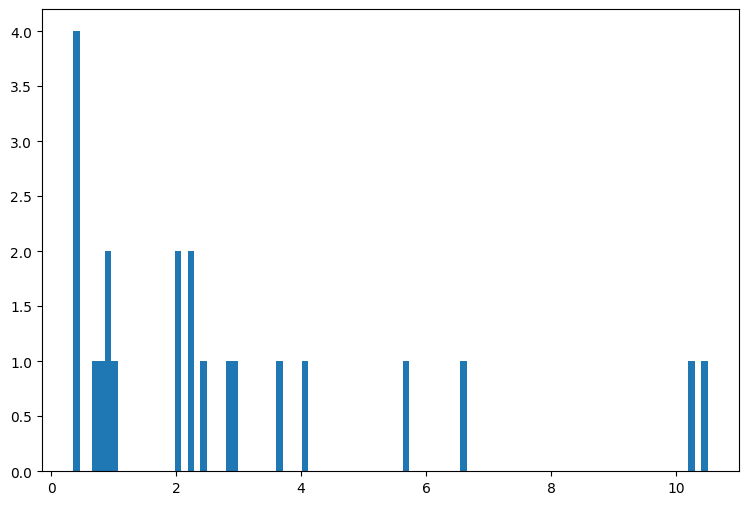

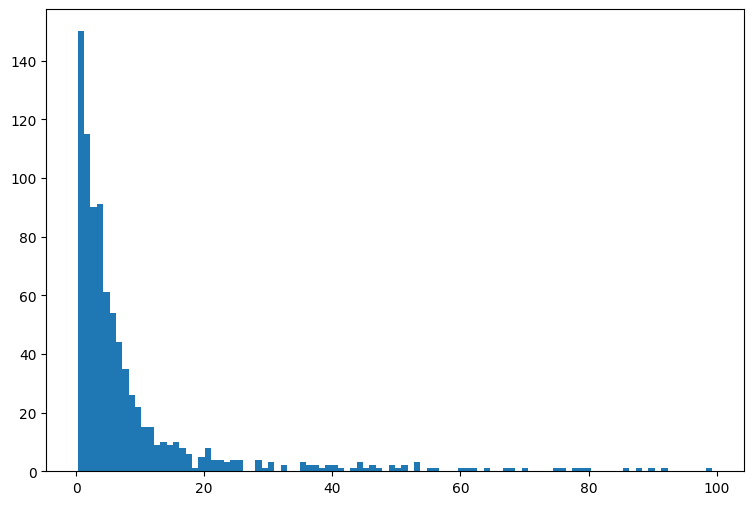

In [4]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

r_trunc_galacticus = nodedata[GalacticusParameters.TNFW_RADIUS_TRUNCATION] * 1E3
r_trunc_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RT] for sh in subhalos])


ax.hist(r_trunc_realization[r_trunc_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(r_trunc_galacticus[r_trunc_galacticus < 100],bins=100);


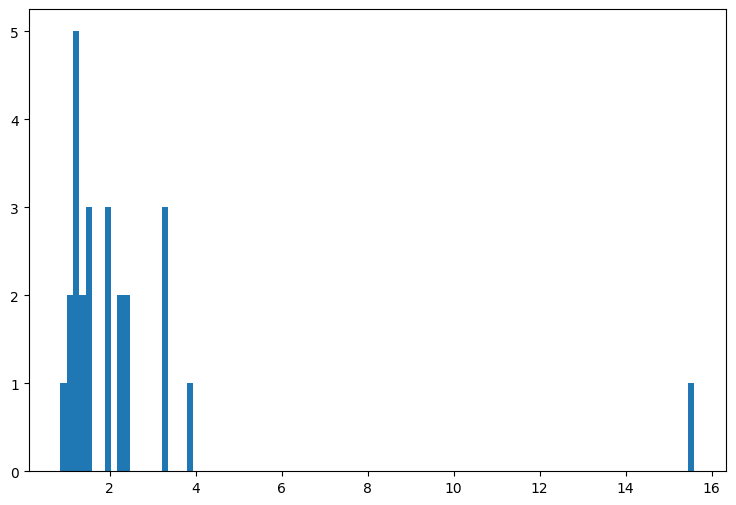

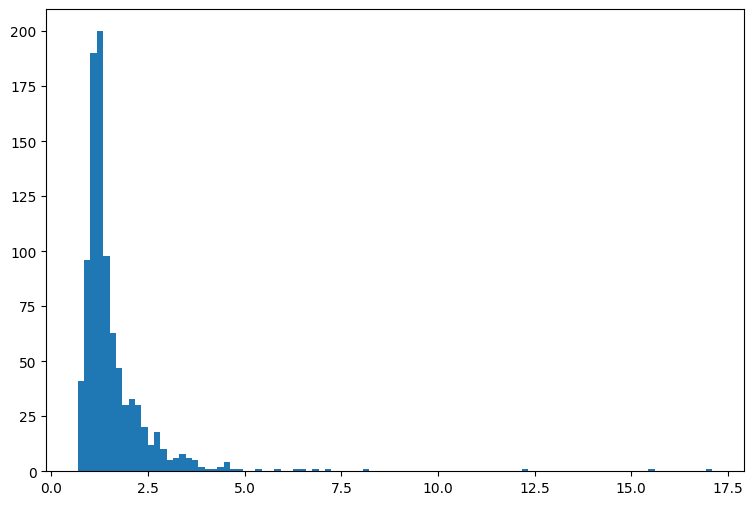

In [5]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rs_galacticus = nodedata[GalacticusParameters.SCALE_RADIUS] * 1E3
rs_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RS] for sh in subhalos])


ax.hist(rs_realization[rs_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rs_galacticus[rs_galacticus < 100],bins=100);

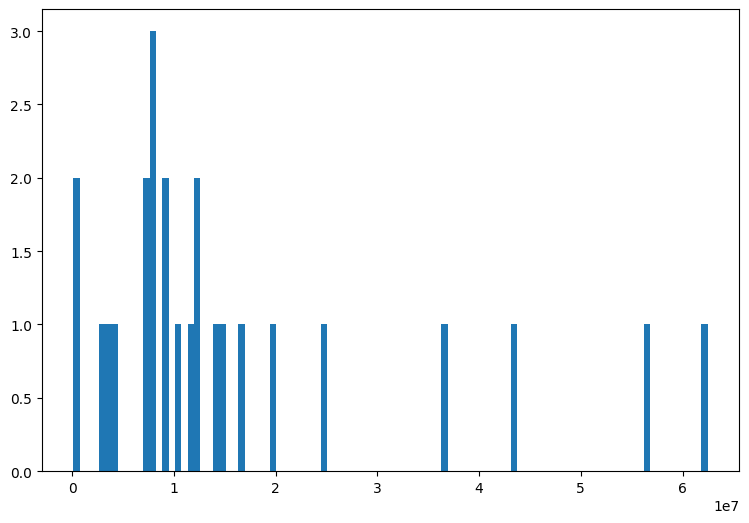

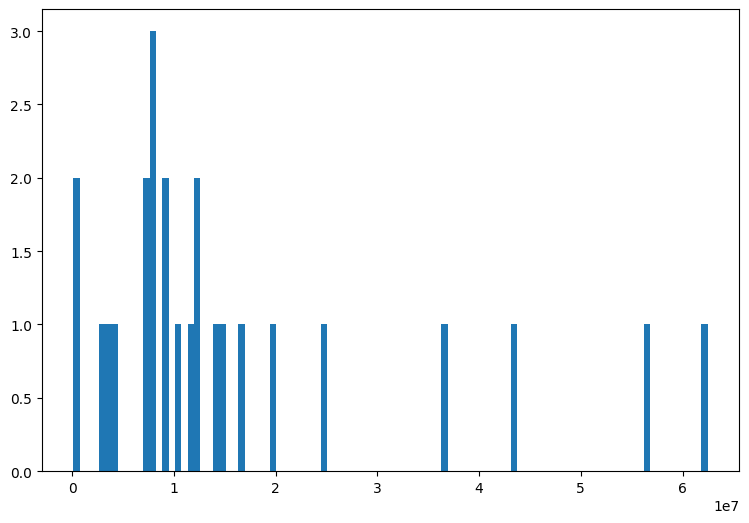

In [6]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rho_s_galacticus = nodedata[GalacticusParameters.TNFW_RHO_S] * 1E3
rho_s_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RHO_S] for sh in subhalos])


ax.hist(rho_s_realization,bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rho_s_realization,bins=100);

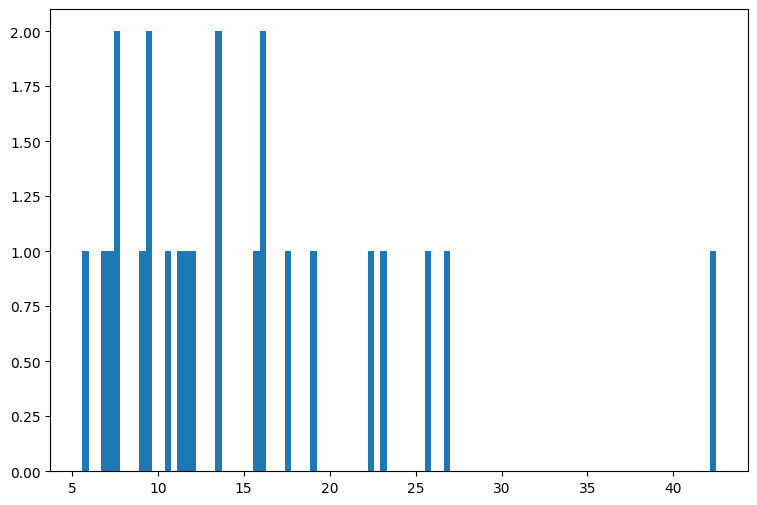

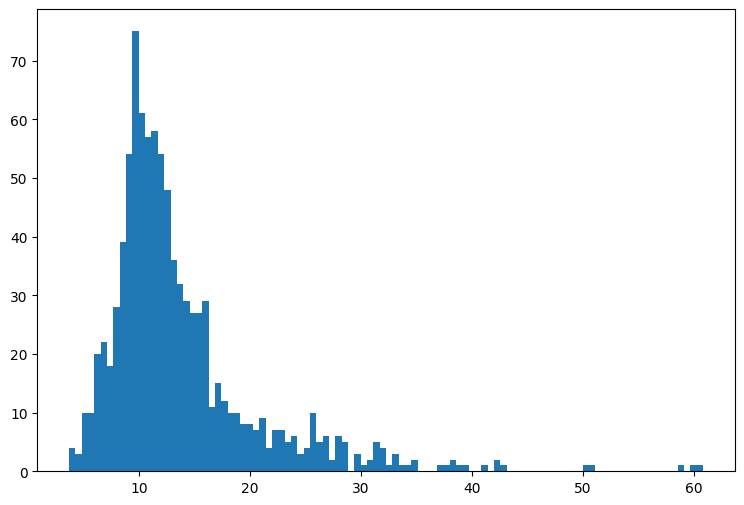

In [7]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rv_galacticus = nodedata[GalacticusParameters.RVIR] * 1E3
rv_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RV] for sh in subhalos])


ax.hist(rv_realization[rv_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rv_galacticus[rv_galacticus < 100],bins=100);

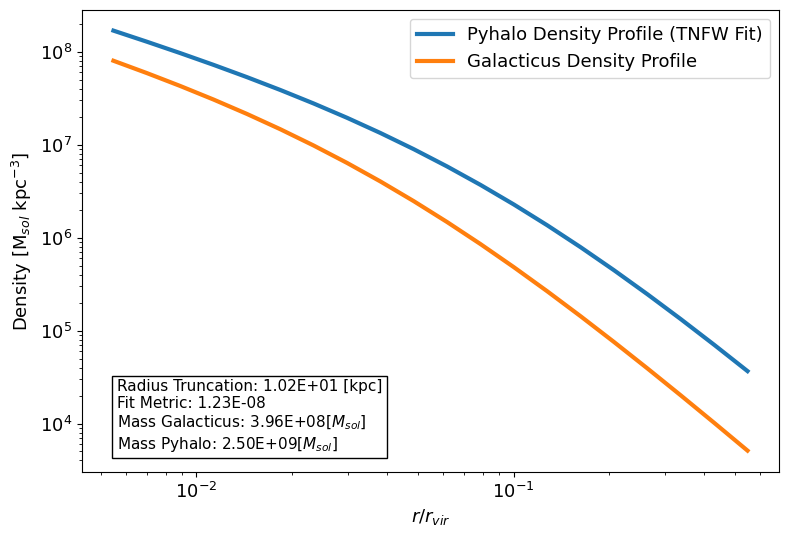

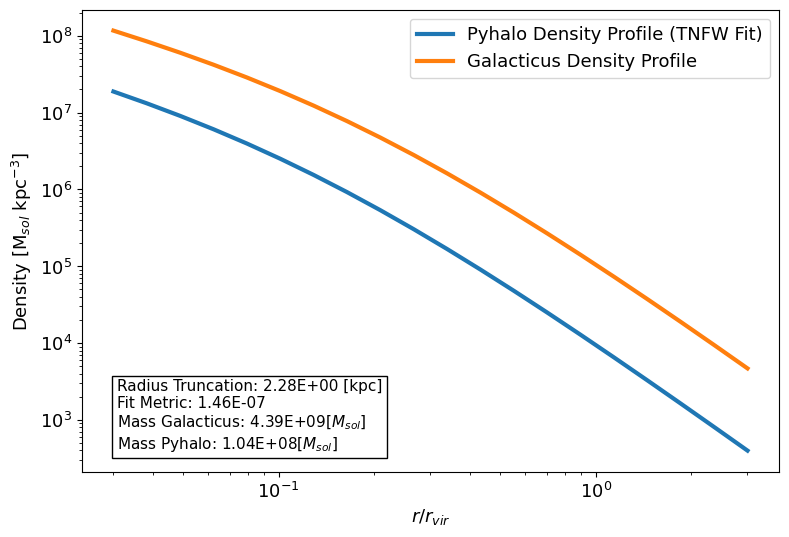

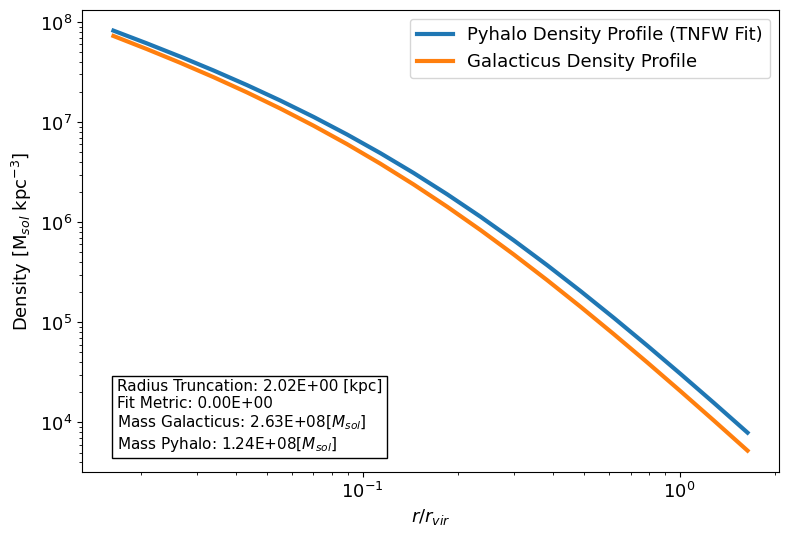

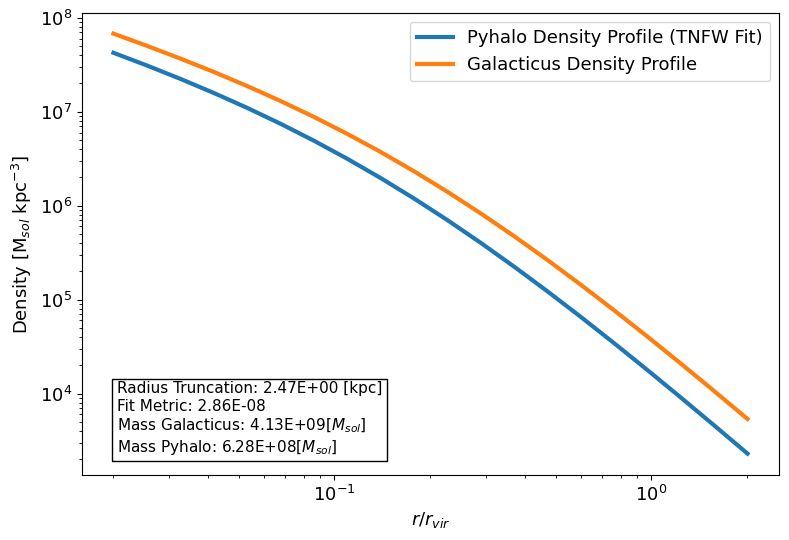

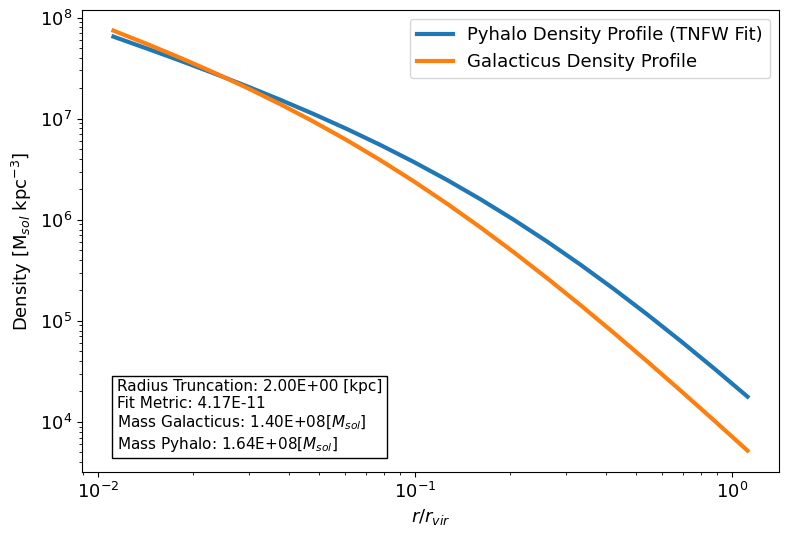

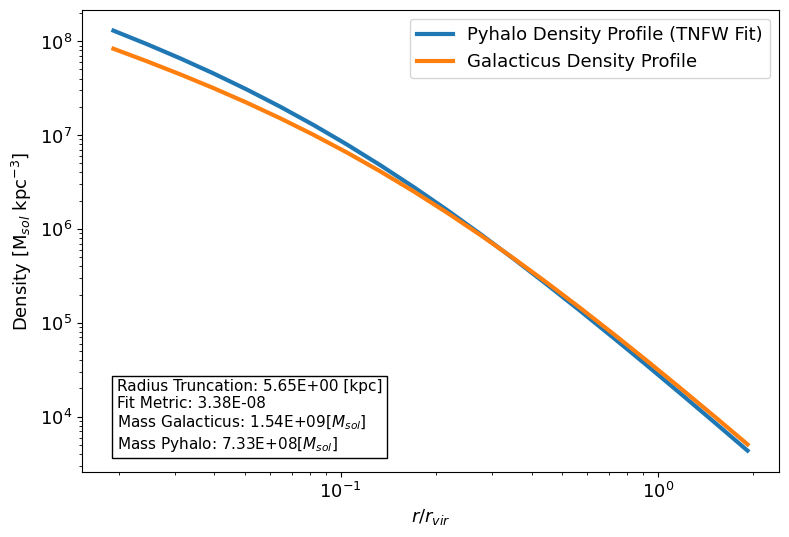

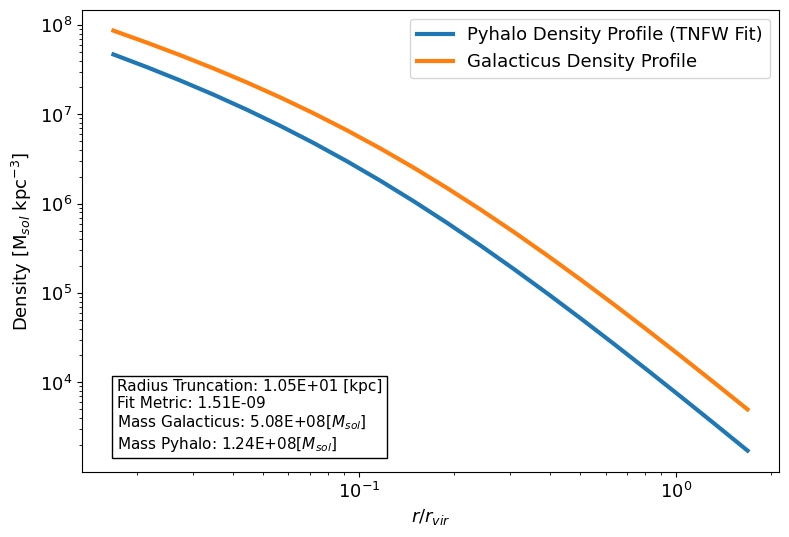

In [10]:
plt.rcParams.update({"font.size":13})

def plt_compare_density(ax:Axes,subhalos:list[TNFWFromParams],nodedata:dict[str,np.ndarray],n:int):
    r = nodedata[GalacticusParameters.DENSITY_PROFILE_RADIUS][n] * 1E3

    subhalo = subhalos[n]
    subhalo.mass_bound_uss_massfraction = False
    
    rv = subhalo.params_physical[TNFWFromParams.KEY_RV]
    
    ax.plot(r / rv,subhalo.density_profile_3d(r),label="Pyhalo Density Profile (TNFW Fit)",linewidth=3)
    ax.plot(r / rv,nodedata[GalacticusParameters.DENSITY_PROFILE][n] / 1E9, label="Galacticus Density Profile",linewidth=3)

    #ax.vlines(x=subhalo.params_physical[TNFWFromParams.KEY_RS],ymin=4E3,ymax=1E8,linestyle="dashed")
    #ax.hlines(y=subhalo.params_physical[TNFWFromParams.KEY_RHO_S] / 4, xmin=2E-1,xmax=2E1,linestyles="dashed")


    txt_rt = f"Radius Truncation: {subhalo.params_physical[TNFWFromParams.KEY_RT]:.2E} [kpc]"
    #print(nodedata[GalacticusParameters.TNFW_RADIUS_TRUNCATION][n])
    txt_fit_metric = f"Fit Metric: {nodedata['metricTidalTruncationNFW'][n]:.2E}"
    txt_mass_galacticus = f"Mass Galacticus: {nodedata[GalacticusParameters.MASS_BOUND][n]:.2E}" + r"[$M_{sol}]$"
    txt_mass_pyhalo = f"Mass Pyhalo: {subhalo.bound_mass:.2E}"+ r"[$M_{sol}$]"
    
    newline = "\n"
    txt_box = txt_rt + newline + txt_fit_metric + newline + txt_mass_galacticus + newline + txt_mass_pyhalo

    ax.text(0.05, 0.05, txt_box,transform=ax.transAxes,fontsize=11, bbox={"boxstyle":"square","facecolor":"white"})

    ax.set_ylabel(r"Density [M$_{sol}$ kpc$^{-3}$]")
    ax.set_xlabel(r"$r/r_{vir}$")

    

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,9)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,21)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,11)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(figsize = (9, 6))
plt_compare_density(ax,subhalos,nodedata,5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

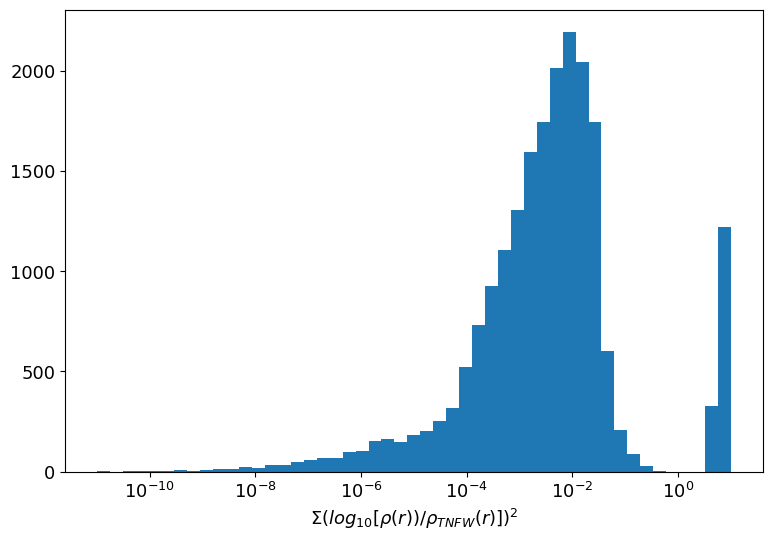

In [ ]:
fitmetric = galacticusfile["Outputs"]["Output1"]['metricTidalTruncationNFW']

fig, ax = plt.subplots(figsize = (9, 6))

ax.hist(fitmetric,bins=np.logspace(-11,1))
ax.set_xlabel(r"$\Sigma (log_{10}[\rho(r))/\rho_{TNFW}(r)])^{2}$")


ax.set_xscale("log")
#ax.set_yscale("log")



8923


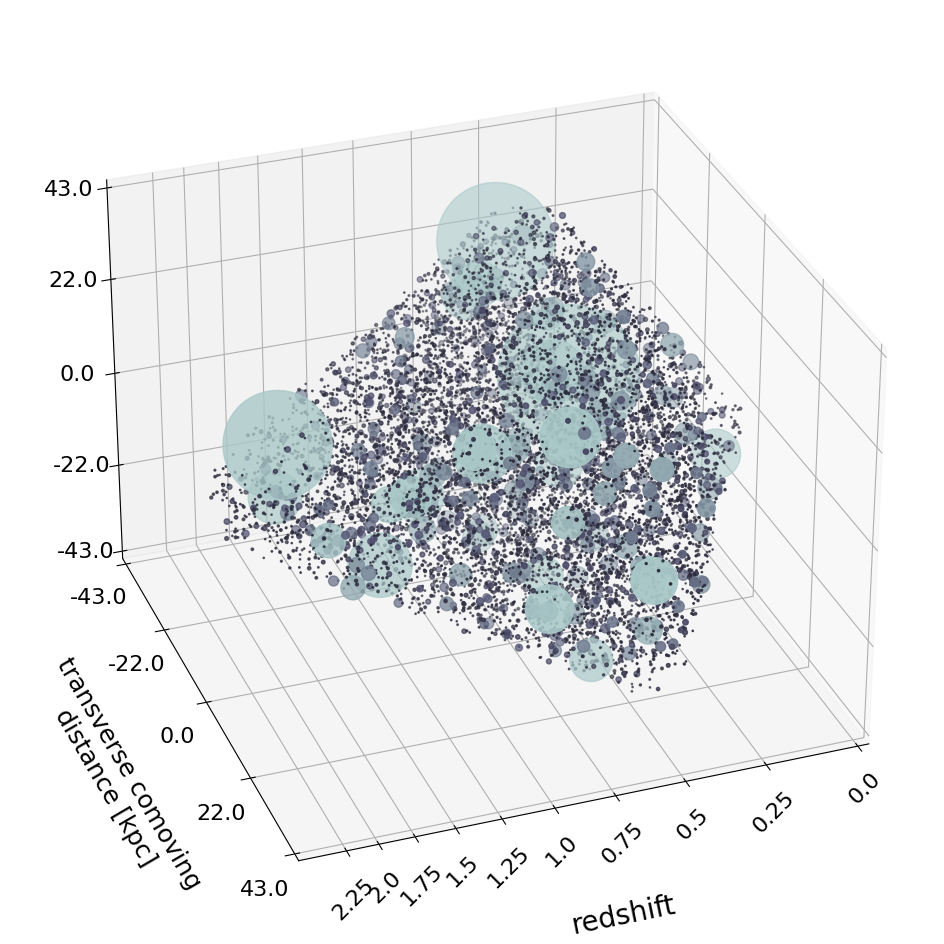

In [ ]:
def filter_r2d(nodedata:dict[str,np.ndarray]):
    r2 = np.asarray((nodedata[GalacticusParameters.X],nodedata[GalacticusParameters.Y]))
    r2 *= 1E3

    filt = np.linalg.norm(r2,axis=0) < 15
    #print(np.sum(filt))
    return filt

realization_galacticus_los = DMFromGalacticus(0.5,2.5,"data/TNFW_example.hdf5",15,dict(cone_opening_angle_arcsec=10),mrange,True,include_field_halos=True,nodedata_filter=filter_r2d)

print(len(realization_galacticus_los.halos))

fig, ax = plt.subplots(figsize = (9, 6))
ax = plt.subplot(111,projection='3d')
fig.set_size_inches(14,12)
realization_galacticus_los.plot(ax)

In [91]:
np.linalg.norm(np.asarray((nodedata[GalacticusParameters.X],nodedata[GalacticusParameters.Y])),axis=0)

array([0.23088457, 0.25345289, 0.41126097, 0.41858023, 0.18501169,
       0.35045005, 0.15885617, 0.3380394 , 0.26312438, 0.35321264,
       0.23121751, 0.12152123, 0.30251231, 0.37855133, 0.29330131,
       0.25729482, 0.23288846, 0.08771448, 0.08447185, 0.11504986,
       0.04084092, 0.15230618, 0.11468239, 0.19629564, 0.08842948,
       0.38036544, 0.2917983 , 0.19911976, 0.30499335, 0.25534207,
       0.16341648, 0.05865851, 0.11067608, 0.19882117, 0.11556736,
       0.13161043, 0.29268931, 0.28502001, 0.22354274, 0.25210614,
       0.29316545, 0.34955084, 0.1622845 , 0.26245841, 0.20873918,
       0.22756747, 0.22316431, 0.22273132, 0.12628769, 0.18021786,
       0.23437441, 0.36191214, 0.37790077, 0.20238022, 0.29668445,
       0.19962696, 0.32476238, 0.25448053, 0.33039152, 0.16775468,
       0.19640514, 0.35892444, 0.09290335, 0.09024209, 0.23536791,
       0.30322853, 0.11631379, 0.16619524, 0.08434801, 0.25789161,
       0.16047373, 0.18094473, 0.20365381, 0.13489415, 0.14266

In [99]:
from pyHalo.Halos.lens_cosmo import LensCosmo

l:LensCosmo = None
